In [1]:
import pandas as pd

excel_filepath = "./uploads/TransactionLogs_Jan2025-June2025.xlsx"
transaction_data_filepath = "./uploads/transaction_data_tagged.csv"

df = pd.read_excel(excel_filepath)
df.head()

,Created,ChargeId,ChargeBoxId,Current,Max Power,EvseId,SiteName,StartTime,StopTime,Duration,Energy,CustomerId,ProductName,SiteOwner,Contract,Zone
0,2025-01-01 01:42:43,166865.0,wbac0241,AC,11.0,216316,Blk 251A Choa Chu Kang Avenue 2 Deck 3A Lot 15...,2024-12-30 19:17:26,2025-01-01 01:42:43,1825.2833,19.440,ncYBJngqWm,Default,HDB,Public (TD116),West
1,2025-01-12 08:56:46,75987312.0,wbac0275,AC,11.0,218338,"Blk 660 Jurong West Street 64 Deck 3A Lot 325,...",2024-12-30 19:44:52,2025-01-12 08:56:43,18072.0000,41.208,5883599,Default,HDB,Public (TD116),West
2,2025-01-02 18:18:36,166906.0,delac0388,AC,7.4,202541,"Blk 691 Woodlands Drive 73 Deck 3A Lot 63, 64, 65",2024-12-30 21:39:05,2025-01-02 18:18:36,4119.5167,45.548,aOxZmjqndD,Default,HDB,Public (TD116),North
3,2025-01-01 10:44:29,75246614.0,delac0102,AC,7.4,130464,"Blk 8C Boon Keng Road Deck 5A Lot 308, 309, 310",2024-12-31 13:37:58,2025-01-01 10:44:28,1267.0000,11.170,4538343,Default,HDB,Public (URA),Central
4,2025-01-01 10:12:55,75246980.0,delac0348,AC,7.4,202477,"Blk 967 Jurong West Street 93 Deck 3A Lot 79, ...",2024-12-31 13:56:09,2025-01-01 10:12:54,1217.0000,73.836,5113628,Default,HDB,Public (TD116),West


In [2]:
df.describe()

,ChargeId,Max Power,StartTime,StopTime,Duration,Energy
count,1.965800e+05,196580.000000,196580,196580,196580.000000,196580.000000
mean,1.474285e+07,35.722414,2025-04-04 18:08:45.060866304,2025-04-04 22:10:42.349699584,242.047906,24.815844
min,1.668650e+05,7.400000,2024-12-30 19:17:26,2025-01-01 00:00:49,0.000000,-3286.160000
25%,2.236878e+05,7.400000,2025-02-18 11:54:31.500000,2025-02-18 14:12:45.500000,45.183300,11.190000
50%,2.775515e+05,7.400000,2025-04-06 14:30:30.500000,2025-04-06 16:46:00,117.316700,22.970000
75%,3.300572e+05,50.000000,2025-05-20 13:32:27,2025-05-20 15:54:31.750000128,346.500000,36.460000
max,8.029052e+07,160.000000,2025-06-30 23:23:38,2025-06-30 23:59:45,113536.183300,215.841000
std,3.009333e+07,45.255474,NaN,NaN,496.272207,17.866924


## Key observations:
- the distribution of session durations is highly skewed; most sessions last under an hour but a few extremely long sessions (>24 hours) inflate the mean.

In [3]:
df.isnull().sum()

Created        1
ChargeId       2
ChargeBoxId    2
Current        2
Max Power      2
EvseId         2
SiteName       2
StartTime      2
StopTime       2
Duration       2
Energy         2
CustomerId     2
ProductName    2
SiteOwner      2
Contract       2
Zone           2
dtype: int64

In [4]:
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196580 entries, 0 to 196579
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Created      196580 non-null  object        
 1   ChargeId     196580 non-null  float64       
 2   ChargeBoxId  196580 non-null  object        
 3   Current      196580 non-null  object        
 4   Max Power    196580 non-null  float64       
 5   EvseId       196580 non-null  object        
 6   SiteName     196580 non-null  object        
 7   StartTime    196580 non-null  datetime64[ns]
 8   StopTime     196580 non-null  datetime64[ns]
 9   Duration     196580 non-null  float64       
 10  Energy       196580 non-null  float64       
 11  CustomerId   196580 non-null  object        
 12  ProductName  196580 non-null  object        
 13  SiteOwner    196580 non-null  object        
 14  Contract     196580 non-null  object        
 15  Zone         196580 non-null  obje

### Feature Engineering

- find out session duration
- find out time since last charge
- find out if its a weekend
- rough user-loyalty ratio (max number of sessions in a single site / total sessions for each user)

In [35]:
tagged_df = pd.read_csv(transaction_data_filepath)
tagged_df.drop(columns=["persona"], inplace=True)
tagged_df.head()

,Created,ChargeId,ChargeBoxId,Current,Max Power,EvseId,SiteName,StartTime,StopTime,Duration,...,ProductName,SiteOwner,Contract,Zone,session_duration_hours,day_of_week,hour_of_day,is_weekend,user_loyalty_ratio,time_since_last_charge_hrs
0,2025-02-04 11:17:01,181234.0,scdc0003,DC,120.0,170808,"ComfortDelGro HQ (Braddell) Lot 1,2,3,4,5,6",2025-02-04 10:15:07,2025-02-04 11:17:01,61.9000,...,CDGE KYC,CDGE,CDG,Central,1.031667,Tuesday,10.0,False,0.8,39.698056
1,2025-02-18 08:12:50,188627.0,scdc0004,DC,120.0,170806,"ComfortDelGro HQ (Braddell) Lot 1,2,3,4,5,6",2025-02-18 07:39:13,2025-02-18 08:12:50,33.6167,...,CDGE KYC,CDGE,CDG,Central,0.560278,Tuesday,7.0,False,0.8,333.401667
2,2025-03-06 14:01:47,201562.0,scdc0003,DC,120.0,170808,"ComfortDelGro HQ (Braddell) Lot 1,2,3,4,5,6",2025-03-06 13:26:14,2025-03-06 14:01:47,35.5500,...,CDGE KYC,CDGE,CDG,Central,0.592500,Thursday,13.0,False,0.8,389.783611
3,2025-03-12 14:41:45,207326.0,scdc0003,DC,120.0,170808,"ComfortDelGro HQ (Braddell) Lot 1,2,3,4,5,6",2025-03-12 14:08:42,2025-03-12 14:41:45,33.0500,...,CDGE Internal,CDGE,CDG,Central,0.550833,Wednesday,14.0,False,0.8,144.707778
4,2025-03-24 14:43:36,221072.0,scdc0003,DC,120.0,170808,"ComfortDelGro HQ (Braddell) Lot 1,2,3,4,5,6",2025-03-24 13:52:34,2025-03-24 14:43:36,51.0333,...,CDGE Internal,CDGE,CDG,Central,0.850556,Monday,13.0,False,0.8,287.731111


In [6]:
# Load the transaction data
xls = pd.ExcelFile(excel_filepath)
df_tx = xls.parse('2025.1-6')

df_tx_cleaned = df_tx[pd.to_datetime(df_tx['Created'], errors='coerce').notnull()].copy()

# Parse datetime columns
df_tx_cleaned['Created'] = pd.to_datetime(df_tx_cleaned['Created'])
df_tx_cleaned['StartTime'] = pd.to_datetime(df_tx_cleaned['StartTime'], errors='coerce')
df_tx_cleaned['StopTime'] = pd.to_datetime(df_tx_cleaned['StopTime'], errors='coerce')

# Convert 'Duration' to numeric and then to minutes
df_tx_cleaned['Duration_min'] = pd.to_numeric(df_tx_cleaned['Duration'], errors='coerce') / 60

# Convert 'Energy' to kWh
df_tx_cleaned['Energy_kWh'] = pd.to_numeric(df_tx_cleaned['Energy'], errors='coerce')

# Extract temporal features
df_tx_cleaned['DayOfWeek'] = df_tx_cleaned['StartTime'].dt.day_name()
df_tx_cleaned['Hour'] = df_tx_cleaned['StartTime'].dt.hour
df_tx_cleaned['Date'] = df_tx_cleaned['StartTime'].dt.date
df_tx_cleaned['Week'] = df_tx_cleaned['StartTime'].dt.isocalendar().week
df_tx_cleaned['Month'] = df_tx_cleaned['StartTime'].dt.month

# Rename column for consistency
df_tx_cleaned.rename(columns={'CustomerId': 'CustomerID'}, inplace=True)

# Preview cleaned data
df_tx_cleaned_preview = df_tx_cleaned[['Created', 'StartTime', 'StopTime', 'Duration_min', 'Energy_kWh', 
                                       'DayOfWeek', 'Hour', 'Date', 'Week', 'Month', 'CustomerID', 'SiteName', 'Zone']].head()

df_tx_cleaned_preview


,Created,StartTime,StopTime,Duration_min,Energy_kWh,DayOfWeek,Hour,Date,Week,Month,CustomerID,SiteName,Zone
0,2025-01-01 01:42:43,2024-12-30 19:17:26,2025-01-01 01:42:43,30.421388,19.440,Monday,19,2024-12-30,1,12,ncYBJngqWm,Blk 251A Choa Chu Kang Avenue 2 Deck 3A Lot 15...,West
1,2025-01-12 08:56:46,2024-12-30 19:44:52,2025-01-12 08:56:43,301.200000,41.208,Monday,19,2024-12-30,1,12,5883599,"Blk 660 Jurong West Street 64 Deck 3A Lot 325,...",West
2,2025-01-02 18:18:36,2024-12-30 21:39:05,2025-01-02 18:18:36,68.658612,45.548,Monday,21,2024-12-30,1,12,aOxZmjqndD,"Blk 691 Woodlands Drive 73 Deck 3A Lot 63, 64, 65",North
3,2025-01-01 10:44:29,2024-12-31 13:37:58,2025-01-01 10:44:28,21.116667,11.170,Tuesday,13,2024-12-31,1,12,4538343,"Blk 8C Boon Keng Road Deck 5A Lot 308, 309, 310",Central
4,2025-01-01 10:12:55,2024-12-31 13:56:09,2025-01-01 10:12:54,20.283333,73.836,Tuesday,13,2024-12-31,1,12,5113628,"Blk 967 Jurong West Street 93 Deck 3A Lot 79, ...",West


### Next Step: Time-Series Analysis

- Total Energy (kWh) Consumed Per Day & Week
- Total Number of Sessions Per Day & Week
- Detect any seasonal or monthly trends

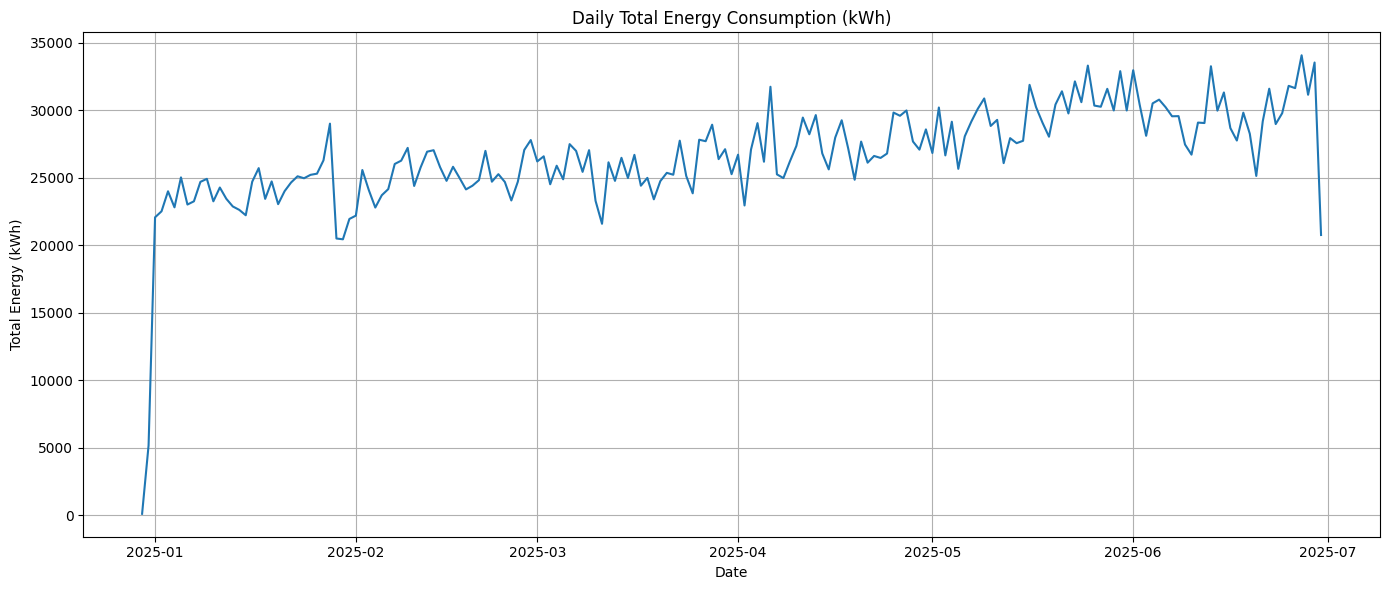

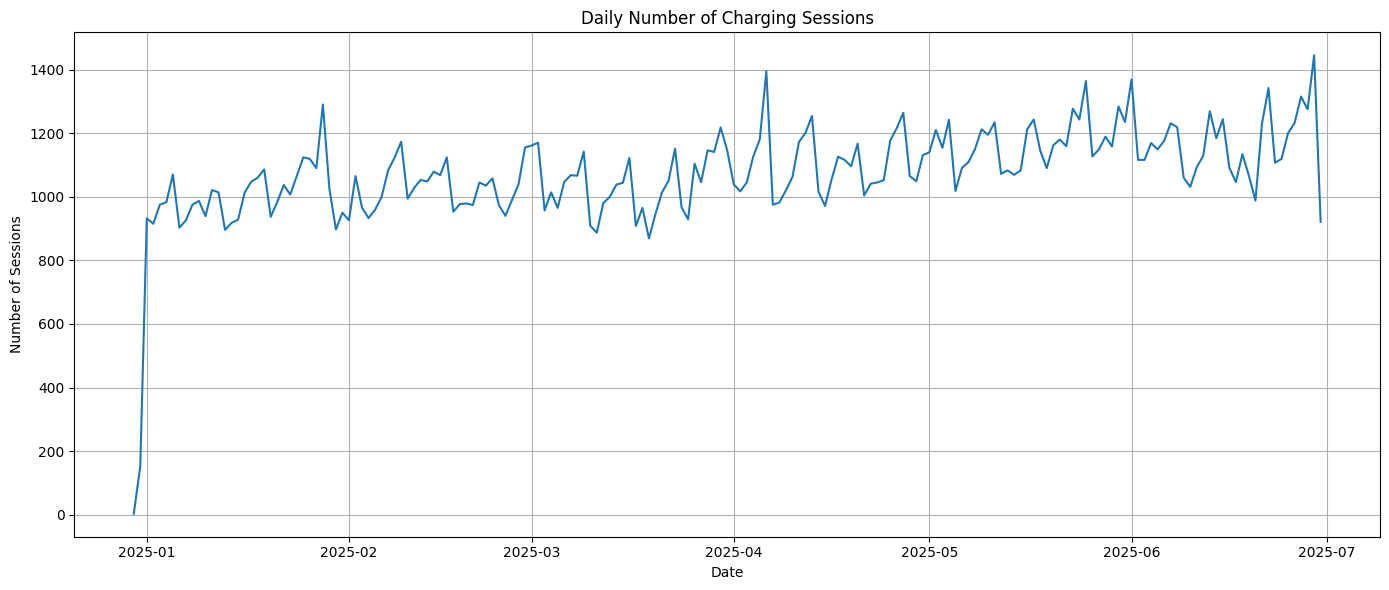

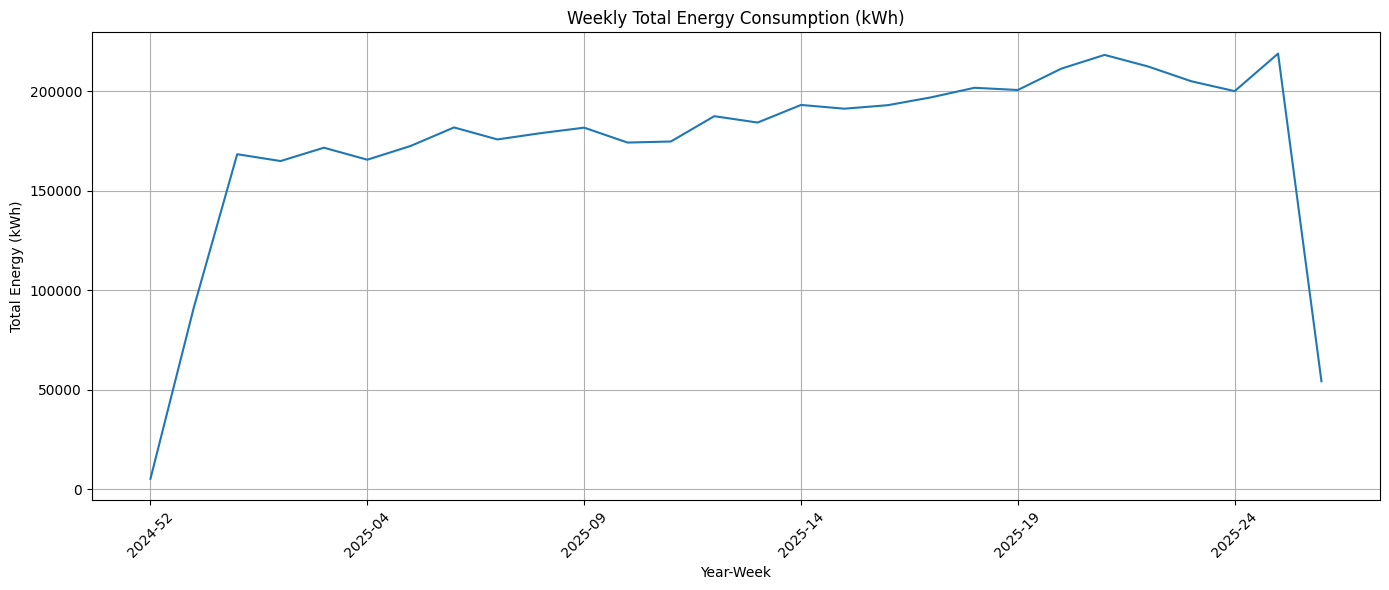

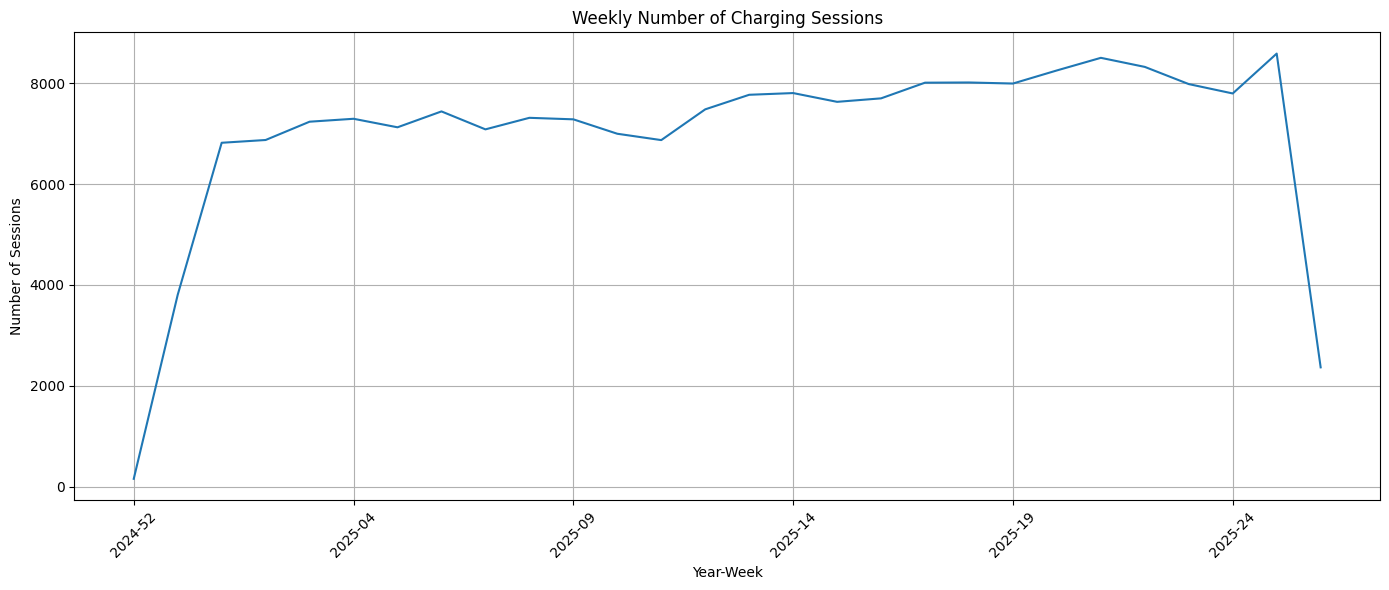

In [ ]:
import matplotlib.pyplot as plt

# Aggregate total energy and session counts per day
daily_energy = df_tx_cleaned.groupby('Date')['Energy_kWh'].sum()
daily_sessions = df_tx_cleaned.groupby('Date').size()

# Aggregate weekly data
df_tx_cleaned['YearWeek'] = df_tx_cleaned['StartTime'].dt.strftime('%Y-%U')
weekly_energy = df_tx_cleaned.groupby('YearWeek')['Energy_kWh'].sum()
weekly_sessions = df_tx_cleaned.groupby('YearWeek').size()

plt.figure(figsize=(14, 6))
daily_energy.plot()
plt.title('Daily Total Energy Consumption (kWh)')
plt.xlabel('Date')
plt.ylabel('Total Energy (kWh)')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
daily_sessions.plot()
plt.title('Daily Number of Charging Sessions')
plt.xlabel('Date')
plt.ylabel('Number of Sessions')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
weekly_energy.plot()
plt.title('Weekly Total Energy Consumption (kWh)')
plt.xlabel('Year-Week')
plt.ylabel('Total Energy (kWh)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
weekly_sessions.plot()
plt.title('Weekly Number of Charging Sessions')
plt.xlabel('Year-Week')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


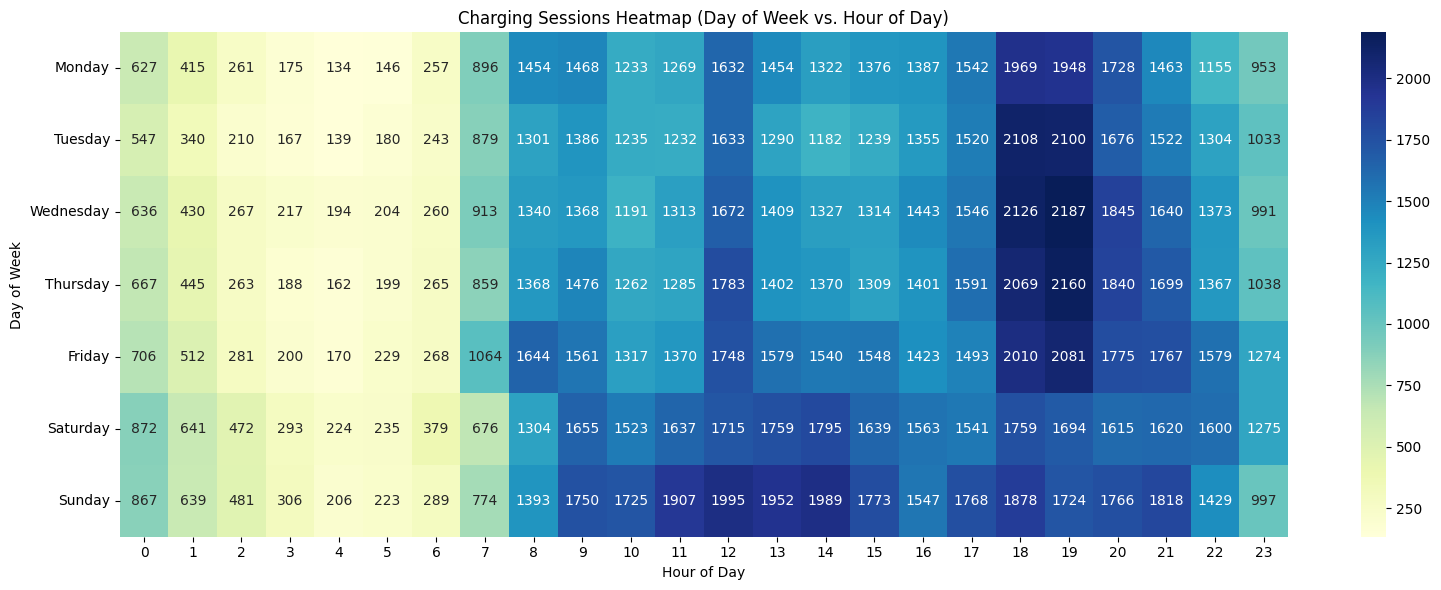

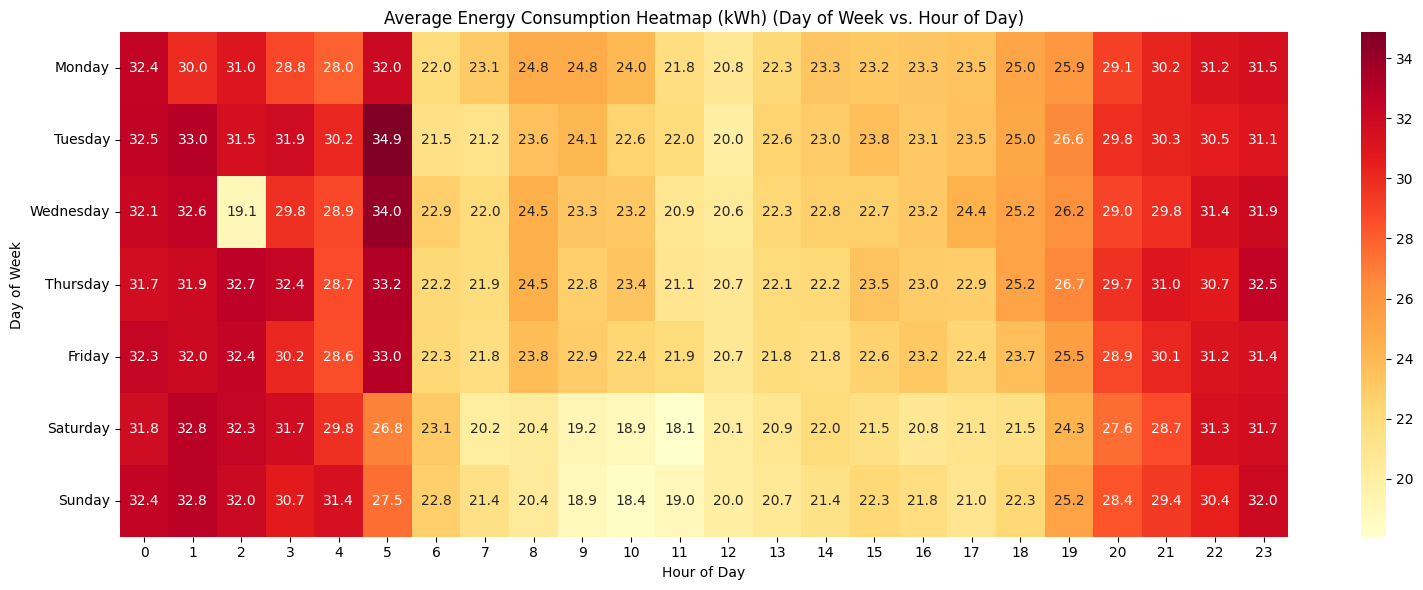

In [ ]:
import seaborn as sns

session_heatmap_data = df_tx_cleaned.pivot_table(index='DayOfWeek', columns='Hour', 
                                                 values='CustomerID', aggfunc='count')

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
session_heatmap_data = session_heatmap_data.reindex(days_order)

energy_heatmap_data = df_tx_cleaned.pivot_table(index='DayOfWeek', columns='Hour', 
                                                values='Energy_kWh', aggfunc='mean')
energy_heatmap_data = energy_heatmap_data.reindex(days_order)

plt.figure(figsize=(16, 6))
sns.heatmap(session_heatmap_data, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title('Charging Sessions Heatmap (Day of Week vs. Hour of Day)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 6))
sns.heatmap(energy_heatmap_data, cmap="YlOrRd", annot=True, fmt=".1f")
plt.title('Average Energy Consumption Heatmap (kWh) (Day of Week vs. Hour of Day)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

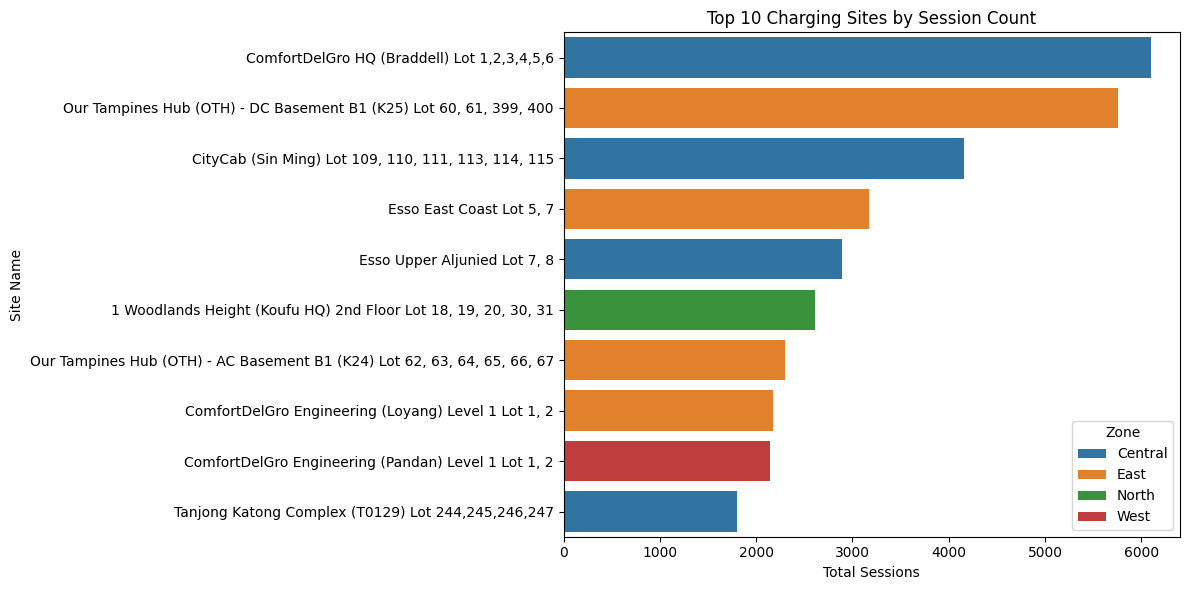

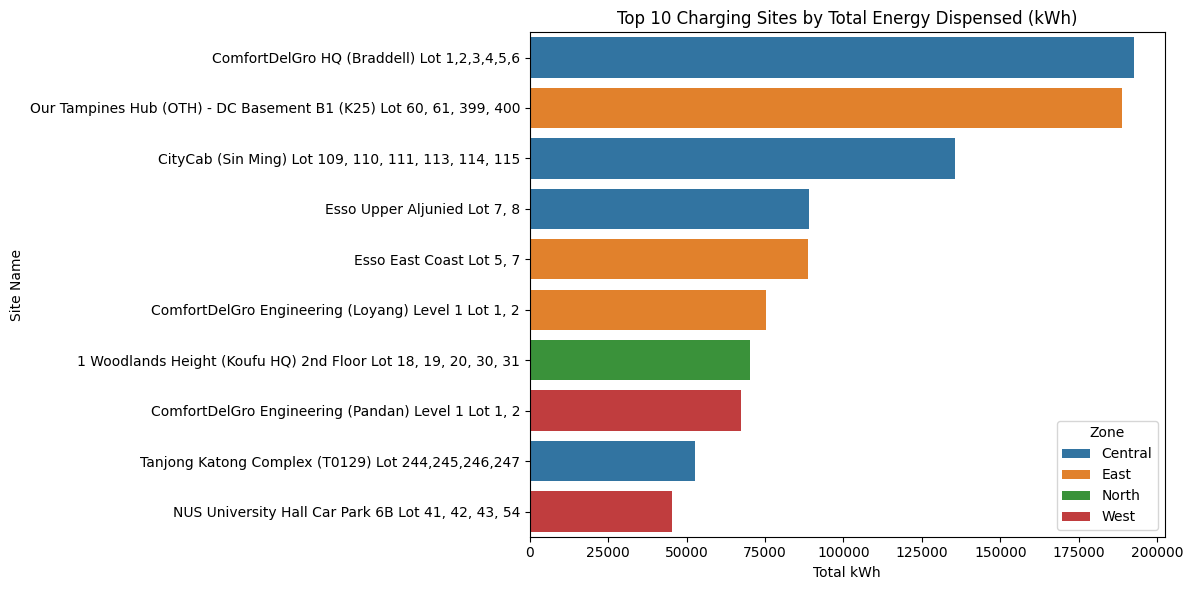

In [ ]:
# Aggregate by SiteName and Zone
site_agg = df_tx_cleaned.groupby(['Zone', 'SiteName']).agg(
    total_sessions=('CustomerID', 'count'),
    total_kWh=('Energy_kWh', 'sum'),
    avg_kWh_per_session=('Energy_kWh', 'mean'),
    avg_duration_min=('Duration_min', 'mean')
).reset_index()

# Top 10 sites by session count
top_sites_by_sessions = site_agg.sort_values(by='total_sessions', ascending=False).head(10)

# Top 10 sites by total kWh
top_sites_by_energy = site_agg.sort_values(by='total_kWh', ascending=False).head(10)

# Plot Top Sites by Sessions
plt.figure(figsize=(12, 6))
sns.barplot(data=top_sites_by_sessions, y='SiteName', x='total_sessions', hue='Zone', dodge=False)
plt.title('Top 10 Charging Sites by Session Count')
plt.xlabel('Total Sessions')
plt.ylabel('Site Name')
plt.tight_layout()
plt.show()

# Plot Top Sites by Energy
plt.figure(figsize=(12, 6))
sns.barplot(data=top_sites_by_energy, y='SiteName', x='total_kWh', hue='Zone', dodge=False)
plt.title('Top 10 Charging Sites by Total Energy Dispensed (kWh)')
plt.xlabel('Total kWh')
plt.ylabel('Site Name')
plt.tight_layout()
plt.show()


### Customer Behavior Analysis

- Total Sessions per Customer
- Average Energy per Customer
- Average Duration per Customer

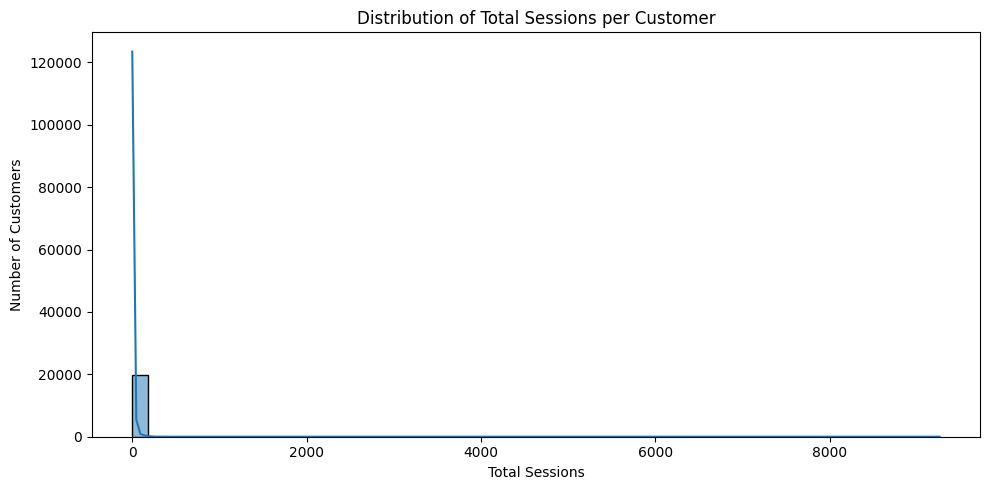

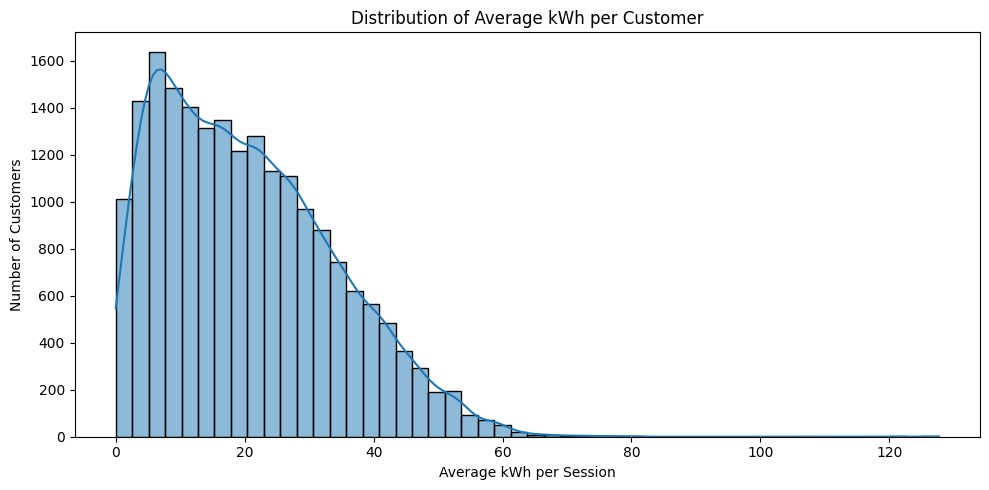

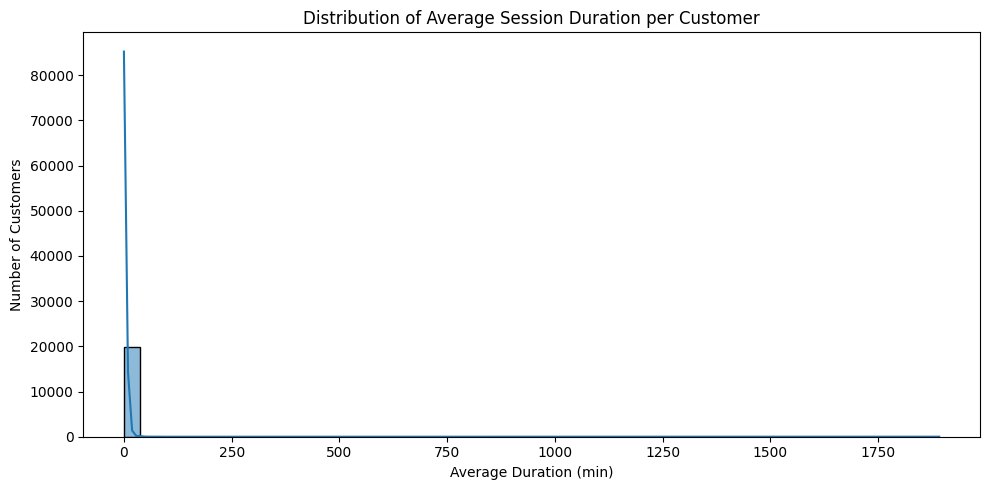

In [ ]:
customer_stats = df_tx_cleaned.groupby('CustomerID').agg(
    total_sessions=('CustomerID', 'count'),
    avg_kWh_per_session=('Energy_kWh', 'mean'),
    avg_duration_min=('Duration_min', 'mean'),
    total_kWh=('Energy_kWh', 'sum')
).reset_index()

plt.figure(figsize=(10, 5))
sns.histplot(customer_stats['total_sessions'], bins=50, kde=True)
plt.title('Distribution of Total Sessions per Customer')
plt.xlabel('Total Sessions')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(customer_stats['avg_kWh_per_session'], bins=50, kde=True)
plt.title('Distribution of Average kWh per Customer')
plt.xlabel('Average kWh per Session')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(customer_stats['avg_duration_min'], bins=50, kde=True)
plt.title('Distribution of Average Session Duration per Customer')
plt.xlabel('Average Duration (min)')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()

### Advanced Multivariate Analysis

- Correlation Matrix of key numerical metrics
- Pairplot to visualize inter-variable trends

In [12]:
# !uv add scikit-learn

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

# Select numerical fields for analysis
features = ['total_sessions', 'avg_kWh_per_session', 'avg_duration_min', 'total_kWh']

# 1. Correlation Matrix
corr_matrix = customer_stats[features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Customer Metrics')
plt.tight_layout()
plt.savefig('./Outputs/customer_correlation_matrix.png')
plt.close()

# 2. Pairplot
sns.pairplot(customer_stats[features])
plt.suptitle('Pairplot of Customer Metrics', y=1.02)
plt.tight_layout()
plt.savefig('./Outputs/customer_pairplot.png')
plt.close()

# 3. Clustering (KMeans)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_stats[features])

kmeans = KMeans(n_clusters=3, random_state=42)
customer_stats['cluster'] = kmeans.fit_predict(scaled_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_stats, x='avg_kWh_per_session', y='avg_duration_min', hue='cluster', palette='viridis')
plt.title('Customer Clusters: kWh per Session vs Duration')
plt.xlabel('Average kWh per Session')
plt.ylabel('Average Duration (min)')
plt.tight_layout()
plt.savefig('./Outputs/customer_clustering.png')
plt.close()

# 4. Regression: Duration vs. Energy
X = customer_stats[['avg_duration_min']]
y = customer_stats['avg_kWh_per_session']
model = LinearRegression().fit(X, y)
preds = model.predict(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=customer_stats['avg_duration_min'], y=customer_stats['avg_kWh_per_session'], label='Data')
plt.plot(customer_stats['avg_duration_min'], preds, color='red', label='Regression Line')
plt.title('Regression: Duration vs. kWh per Session')
plt.xlabel('Average Duration (min)')
plt.ylabel('Average kWh per Session')
plt.legend()
plt.tight_layout()
plt.savefig('./Outputs/customer_regression.png')
plt.close()

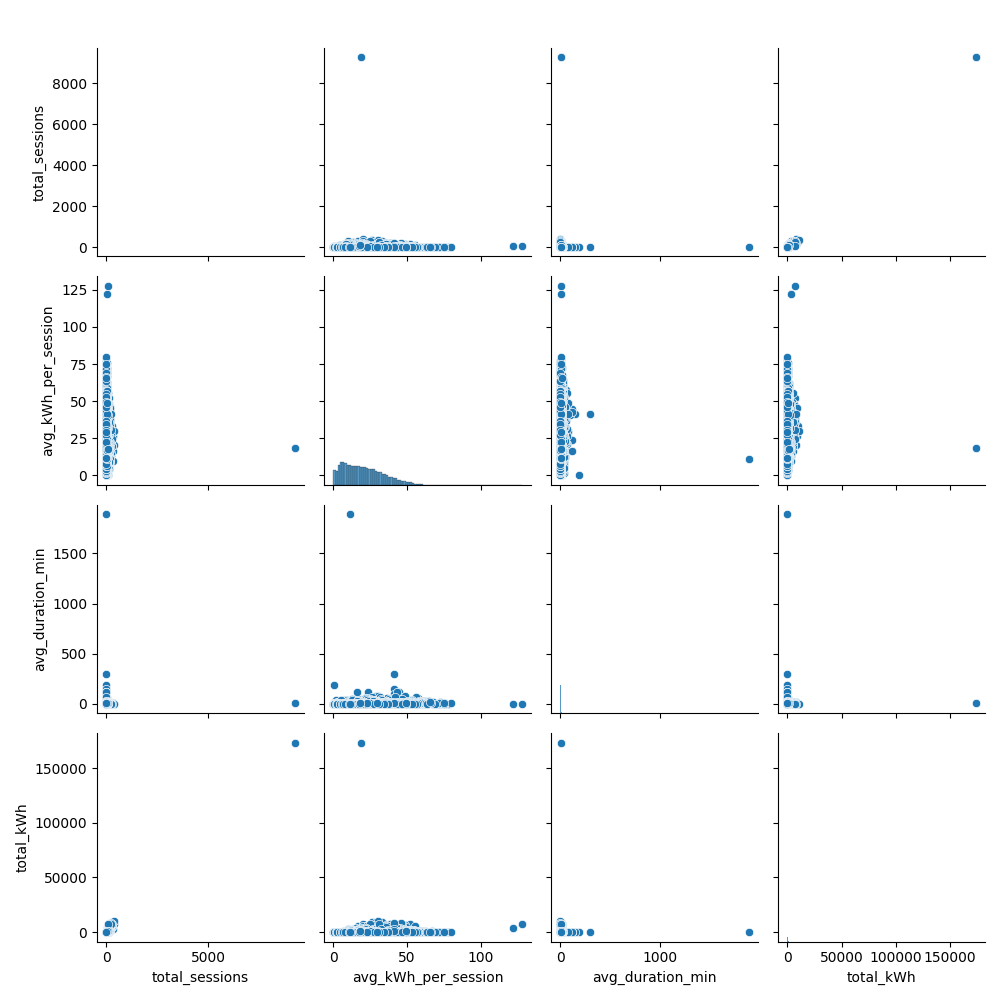

In [ ]:
from PIL import Image

# image_paths = [
#     "./Outputs/customer_correlation_matrix.png",
#     "./Outputs/customer_pairplot.png",
#     "./Outputs/customer_clustering.png",
#     "./Outputs/customer_regression.png"
# ]

Image.open('./Outputs/customer_pairplot.png')

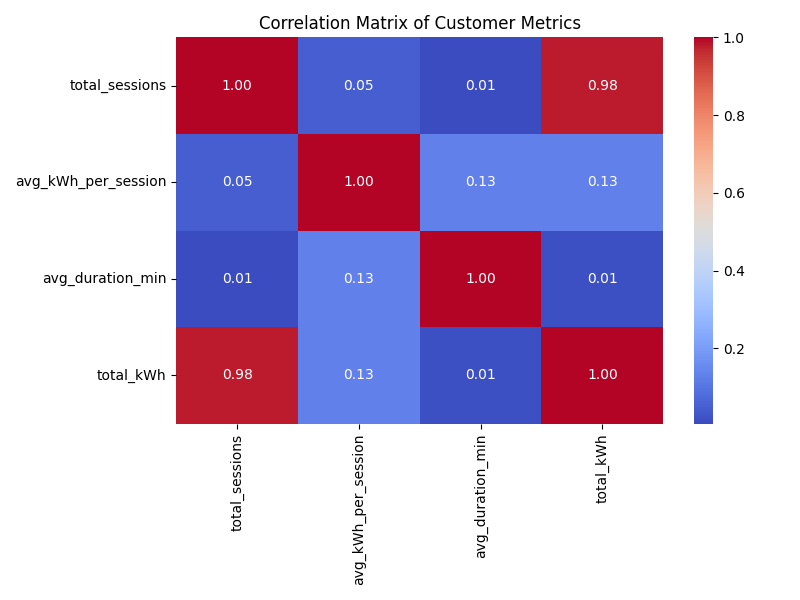

In [19]:
Image.open('./Outputs/customer_correlation_matrix.png')

In [ ]:
# Charger Gun-Level Utilization Analysis

# Aggregate sessions, total energy and average duration per EVSE ID
evse_util = df_tx_cleaned.groupby('EvseId').agg(
    total_sessions=('CustomerID', 'count'),
    total_kWh=('Energy_kWh', 'sum'),
    avg_duration_min=('Duration_min', 'mean'),
    total_duration_min=('Duration_min', 'sum')
).reset_index()

# Add utilization percentage over 6 months (total minutes in 6 months = 6 * 30 * 24 * 60)
total_minutes_6mo = 6 * 30 * 24 * 60
evse_util['utilization_percent'] = (evse_util['total_duration_min'] / total_minutes_6mo) * 100

# Get top 10 EVSEs by utilization
top_evse_util = evse_util.sort_values(by='utilization_percent', ascending=False).head(10)

# Plot top 10 EVSE utilization
plt.figure(figsize=(12, 6))
sns.barplot(data=top_evse_util, y='EvseId', x='utilization_percent', palette='mako')
plt.title('Top 10 Charger Guns by Utilization Percentage (Jan–Jun 2025)')
plt.xlabel('Utilization (%)')
plt.ylabel('Charger Gun (EvseId)')
plt.tight_layout()
plt.savefig('./Outputs/evse_utilization_top10.png')
plt.close()

top_evse_util[['EvseId', 'total_sessions', 'total_kWh', 'utilization_percent']]

/tmp/ipykernel_1667281/2415300325.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_evse_util, y='EvseId', x='utilization_percent', palette='mako')


,EvseId,total_sessions,total_kWh,utilization_percent
467,180150,285,9725.640,0.997713
212,140494,385,8588.149,0.990425
726,218325,161,3073.903,0.984140
167,137594,395,12167.749,0.972972
1355,98448,251,8614.222,0.956467
356,142670,288,9315.213,0.923567
353,142667,313,9780.525,0.917460
594,202581,348,9742.044,0.898689
586,202571,314,10021.583,0.893967
60,126739,364,10122.510,0.890217


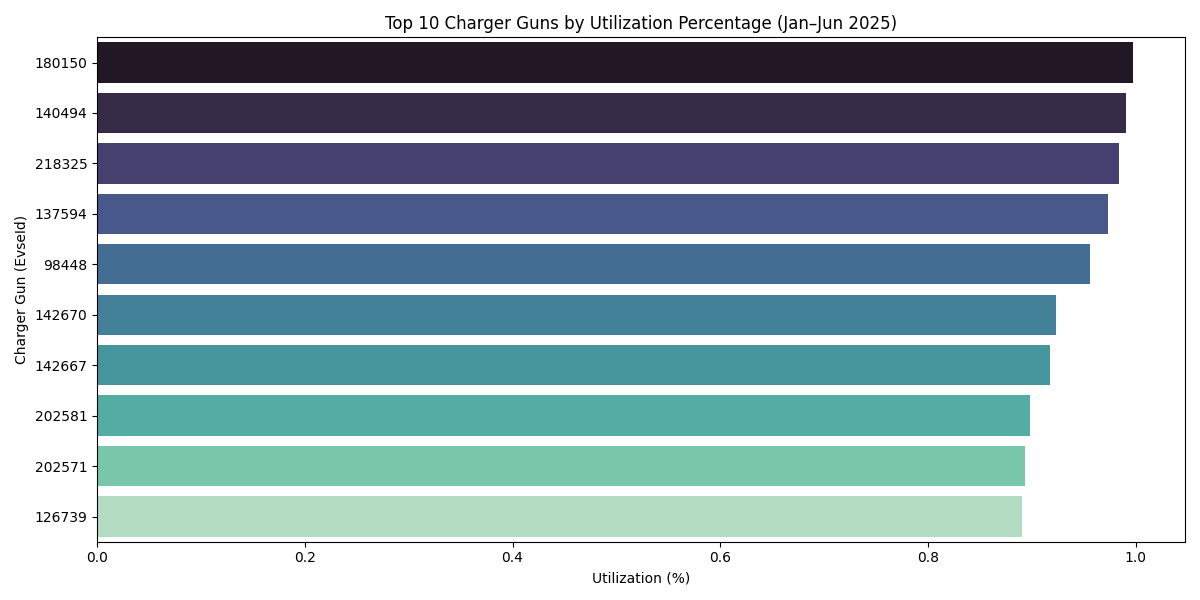

In [22]:
Image.open('./Outputs/evse_utilization_top10.png')

In [ ]:
# Temporal Pattern Shift Between Zones

# Aggregate energy by Zone and Hour
zone_hourly = df_tx_cleaned.groupby(['Zone', 'Hour'])['Energy_kWh'].sum().reset_index()

# Pivot for heatmap format
zone_hourly_pivot = zone_hourly.pivot(index='Zone', columns='Hour', values='Energy_kWh')

plt.figure(figsize=(14, 6))
sns.heatmap(zone_hourly_pivot, cmap='YlGnBu', annot=False)
plt.title('Hourly Energy Consumption by Zone (Jan–June 2025)')
plt.xlabel('Hour of Day')
plt.ylabel('Zone')
plt.tight_layout()
plt.savefig('./Outputs/zone_hourly_heatmap.png')
plt.close()

zone_hourly_pivot.head()

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Zone,,,,,,,,,,,,,,,,,,,,,
Central,35316.803,23531.372,16538.517,15185.130,11835.422,9026.996,12765.852,40183.460,77328.492,95663.417,...,75026.057,76122.549,68352.732,59447.788,71182.098,78924.6654,81185.508,83895.160,67045.766,54565.416
East,20651.333,16360.314,11924.192,7364.504,4568.391,16061.073,9938.142,26150.820,38404.494,41672.570,...,44182.663,41144.070,39447.631,40478.266,54082.474,61857.1810,54134.582,43197.443,40072.869,31213.167
North,50808.123,36080.469,19053.418,10756.982,7781.955,8643.988,11120.562,27823.495,42426.839,36979.266,...,47802.435,52903.156,57023.340,62091.541,89631.025,92971.9320,95348.129,94792.688,84774.278,68650.707
West,51505.750,34242.615,20637.534,14315.112,12023.855,10733.766,10187.998,37548.932,68946.984,61519.318,...,67074.932,61822.972,63640.988,87096.126,120168.646,125004.9760,123954.706,123296.848,111808.428,85301.619


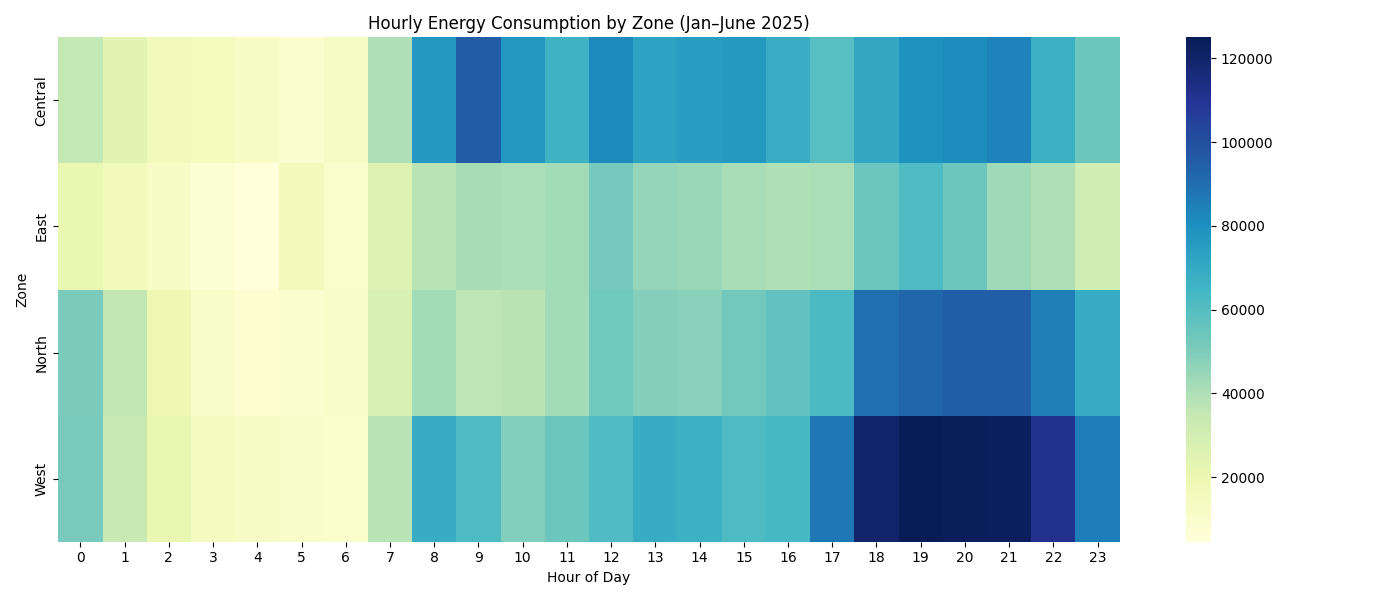

In [24]:
Image.open('./Outputs/zone_hourly_heatmap.png')

In [ ]:
#Repeat Customer Retention Analysis

# Extract month and customer pairs
customer_monthly = df_tx_cleaned[['CustomerID', 'Month']].drop_duplicates()

# Count how many months each customer was active
customer_month_count = customer_monthly.groupby('CustomerID').count().reset_index()
customer_month_count.columns = ['CustomerID', 'active_months']

# Distribution of customers by number of months active
retention_dist = customer_month_count['active_months'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
sns.barplot(x=retention_dist.index, y=retention_dist.values, palette='viridis')
plt.title('Repeat Customer Retention (Jan–Jun 2025)')
plt.xlabel('Number of Active Months')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.savefig('./Outputs/repeat_customer_retention.png')
plt.close()

retention_dist

/tmp/ipykernel_1667281/1542441820.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=retention_dist.index, y=retention_dist.values, palette='viridis')


active_months
1    10423
2     3912
3     2303
4     1579
5      878
6      823
7       26
Name: count, dtype: int64

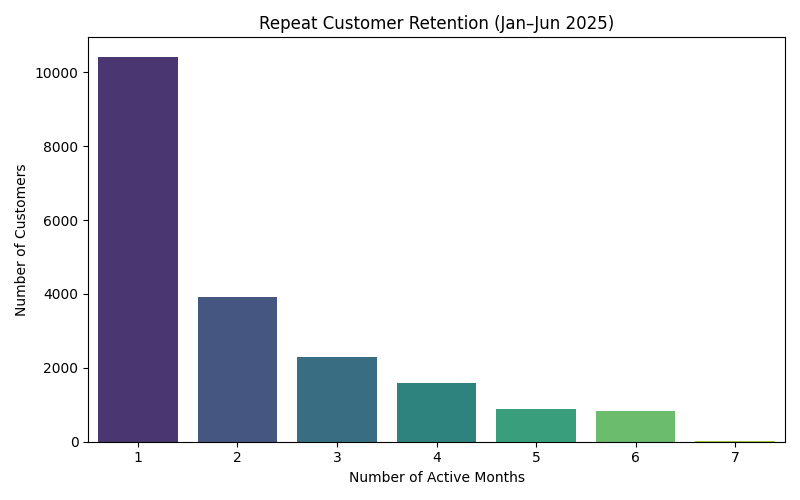

In [26]:
Image.open('./Outputs/repeat_customer_retention.png')

### Insights:

- Over 10,000 users were one-time customers.
- Only ~8% of customers used charging services all 6 months.

Suggests need for improved loyalty or incentive programs (?)

## Demand Response Strategy & Revenue Model Analysis

### 1. Revenue Model: Discharging to Grid (V2G)
Vehicle-to-Grid (V2G) enables EVs to supply power back to the grid during peak demand.

We model potential revenue as:

Revenue = Energy Exported (kWh) × Dynamic Grid Price ($/kWh)

<!-- Key Data Needed:
Time, Energy_kWh, CustomerID -->

### 2. Customer Group Identification for Throttling
Throttling means reducing charging speed to:

- Shift loads to off-peak times
- Avoid grid overloads
- Respond to dynamic pricing

Candidate Criteria:
- Frequent daytime charging (when demand is high)
- Long session durations (allowing flexibility to slow down)
- Not already charging at max speed

We can identify these customers by analyzing:

- Hour-of-day usage patterns
- Duration vs. Energy delivered (lower power draw implies capacity for throttling)

### 3. Correlating Charging Time with Pricing - Analysis

- Average energy delivered by hour
- Overlay real or simulated electricity price curves
- Identify peak price periods overlapping with charging peaks

In [29]:
# Calculate number of sessions per customer during peak hours (12 PM to 8 PM) on a per-day basis
df_tx['Duration_min'] = pd.to_numeric(df_tx['Duration'], errors='coerce') / 60
df_tx['Energy_kWh'] = pd.to_numeric(df_tx['Energy'], errors='coerce')
df_tx['Hour'] = df_tx['StartTime'].dt.hour
# df_tx.rename(columns={'CustomerId': 'CustomerID'}, inplace=True)

peak_hours_df = df_tx[(df_tx['Hour'] >= 12) & (df_tx['Hour'] <= 20)].copy()
peak_hours_df['Date'] = peak_hours_df['StartTime'].dt.date

# Sessions per customer per day
daily_sessions = peak_hours_df.groupby(['CustomerID', 'Date']).size().reset_index(name='daily_sessions')

# Calculate 90th percentile of daily session counts
session_threshold = daily_sessions['daily_sessions'].quantile(0.90)

# 90th percentile of session durations during peak hours
duration_threshold = peak_hours_df['Duration_min'].quantile(0.90)

# Aggregate customer-level stats
customer_peak_stats = peak_hours_df.groupby('CustomerID').agg(
    avg_sessions_per_day=('StartTime', lambda x: x.count() / x.dt.date.nunique()),
    avg_duration_peak=('Duration_min', 'mean'),
    total_peak_sessions=('CustomerID', 'count')
).reset_index()

# Identify candidates based on thresholds
throttle_candidates = customer_peak_stats[
    (customer_peak_stats['avg_sessions_per_day'] >= session_threshold) &
    (customer_peak_stats['avg_duration_peak'] >= duration_threshold)
]

# Top 10 throttle candidates
top_throttle_candidates = throttle_candidates.sort_values(by='total_peak_sessions', ascending=False).head(10)
session_threshold, duration_threshold, top_throttle_candidates


(np.float64(1.0),
 np.float64(11.218055),
           CustomerID  avg_sessions_per_day  avg_duration_peak  \
 9097      NIPHieLJvl              1.075862          12.948894   
 15016     xYDGVoSGlA              1.021583          16.825831   
 7981   GS_zizHRkeOim              1.000000          14.193855   
 11506     bxisUsWQst              1.000000          15.982447   
 12380     hPzoZyTizP              1.043103          14.357312   
 8492      JSkiWnvmVa              1.009091          14.013604   
 11177     aDlTEjIIVs              1.022472          12.154988   
 9305      OWbgQGrzku              1.075949          11.422085   
 14567     ulLtxYJcLy              1.000000          13.071233   
 12369     hLoIoqAznY              1.000000          12.362949   
 
        total_peak_sessions  
 9097                   156  
 15016                  142  
 7981                   139  
 11506                  125  
 12380                  121  
 8492                   111  
 11177              

### Top Peak-Hour Throttling Candidates

| CustomerID     | Avg Sessions/Day | Avg Duration (min) | Total Peak Sessions |
| -------------- | ---------------- | ------------------ | ------------------- |
| NIPHieLJvl     | 1.08             | 12.95              | 156                 |
| xYDGVoSGlA     | 1.02             | 16.83              | 142                 |
| GS\_zizHRkeOim | 1.00             | 14.19              | 139                 |
| bxisUsWQst     | 1.00             | 15.98              | 125                 |
| hPzoZyTizP     | 1.04             | 14.36              | 121                 |


In [ ]:
# Step 1: Identify customers who charge daily (on average) during peak hours
unique_customers = df_tx['CustomerID'].nunique()

# Count unique peak-hour sessions per customer per day
peak_daily_sessions = peak_hours_df.groupby(['CustomerID', 'Date']).size().reset_index(name='session_count')

# Count days each customer had sessions in peak hours
days_active_peak = peak_daily_sessions.groupby('CustomerID')['Date'].nunique().reset_index(name='days_active')

total_days = peak_hours_df['Date'].nunique()
days_active_peak['active_ratio'] = days_active_peak['days_active'] / total_days

daily_peak_chargers = days_active_peak[days_active_peak['active_ratio'] >= 0.9]
percent_daily_peak_users = (len(daily_peak_chargers) / unique_customers) * 100

# Step 2: Temporal dynamics - daily & monthly activity trend for these users
top_daily_peak_ids = daily_peak_chargers['CustomerID'].tolist()
df_top_daily = df_tx[df_tx['CustomerID'].isin(top_daily_peak_ids)].copy()
df_top_daily['Date'] = df_top_daily['StartTime'].dt.date
df_top_daily['Week'] = df_top_daily['StartTime'].dt.to_period('W').astype(str)
df_top_daily['Month'] = df_top_daily['StartTime'].dt.to_period('M').astype(str)

daily_counts = df_top_daily.groupby('Date')['CustomerID'].count()
weekly_counts = df_top_daily.groupby('Week')['CustomerID'].count()
monthly_counts = df_top_daily.groupby('Month')['CustomerID'].count()

percent_daily_peak_users, daily_counts, weekly_counts, monthly_counts

(0.015042117930204574,
 Date
 2025-01-01    3
 2025-01-02    5
 2025-01-03    5
 2025-01-04    5
 2025-01-05    5
              ..
 2025-06-26    5
 2025-06-27    5
 2025-06-28    5
 2025-06-29    5
 2025-06-30    4
 Name: CustomerID, Length: 181, dtype: int64,
 Week
 2024-12-30/2025-01-05    23
 2025-01-06/2025-01-12    36
 2025-01-13/2025-01-19    35
 2025-01-20/2025-01-26    30
 2025-01-27/2025-02-02    29
 2025-02-03/2025-02-09    32
 2025-02-10/2025-02-16    32
 2025-02-17/2025-02-23    30
 2025-02-24/2025-03-02    33
 2025-03-03/2025-03-09    30
 2025-03-10/2025-03-16    30
 2025-03-17/2025-03-23    31
 2025-03-24/2025-03-30    29
 2025-03-31/2025-04-06    31
 2025-04-07/2025-04-13    34
 2025-04-14/2025-04-20    32
 2025-04-21/2025-04-27    34
 2025-04-28/2025-05-04    32
 2025-05-05/2025-05-11    33
 2025-05-12/2025-05-18    35
 2025-05-19/2025-05-25    34
 2025-05-26/2025-06-01    29
 2025-06-02/2025-06-08    27
 2025-06-09/2025-06-15    34
 2025-06-16/2025-06-22    31
 2025-0

### Peak-Hour Daily Users: Data-Driven Insights:
- Only ~1.5% of users charge during peak hours (12 PM–8 PM) on 90%+ of days over 6 months.

Daily Sessions:
- Consistent daily engagement with 4–5 users per day
- No major dips or spikes over the 6 months

Weekly Sessions:
- Weekly totals remain steady, typically ~30–35 sessions/week
- Minor drops in early June and late May

<em>Observation: Usage is remarkably stable with minor seasonal dips.</em>

In [31]:
# Plot daily usage trend
plt.figure(figsize=(12, 5))
daily_counts.plot()
plt.title('Daily Charging Sessions by High-Engagement Peak-Hour Users')
plt.xlabel('Date')
plt.ylabel('Number of Sessions')
plt.tight_layout()
plt.savefig('./Outputs/peak_user_daily_trend.png')
plt.close()

# Plot weekly trend
plt.figure(figsize=(12, 5))
weekly_counts.plot(marker='o')
plt.title('Weekly Charging Sessions by High-Engagement Peak-Hour Users')
plt.xlabel('Week')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./Outputs/peak_user_weekly_trend.png')
plt.close()

# Plot monthly trend
plt.figure(figsize=(8, 5))
monthly_counts.plot(kind='bar')
plt.title('Monthly Charging Sessions by High-Engagement Peak-Hour Users')
plt.xlabel('Month')
plt.ylabel('Number of Sessions')
plt.tight_layout()
plt.savefig('./Outputs/peak_user_monthly_trend.png')
plt.close()

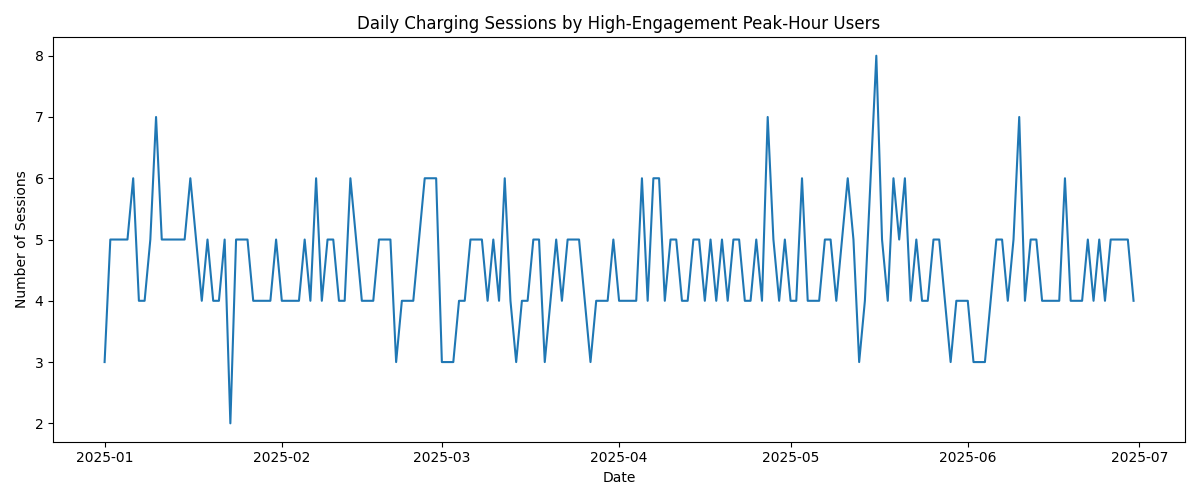

In [32]:
Image.open('./Outputs/peak_user_daily_trend.png')

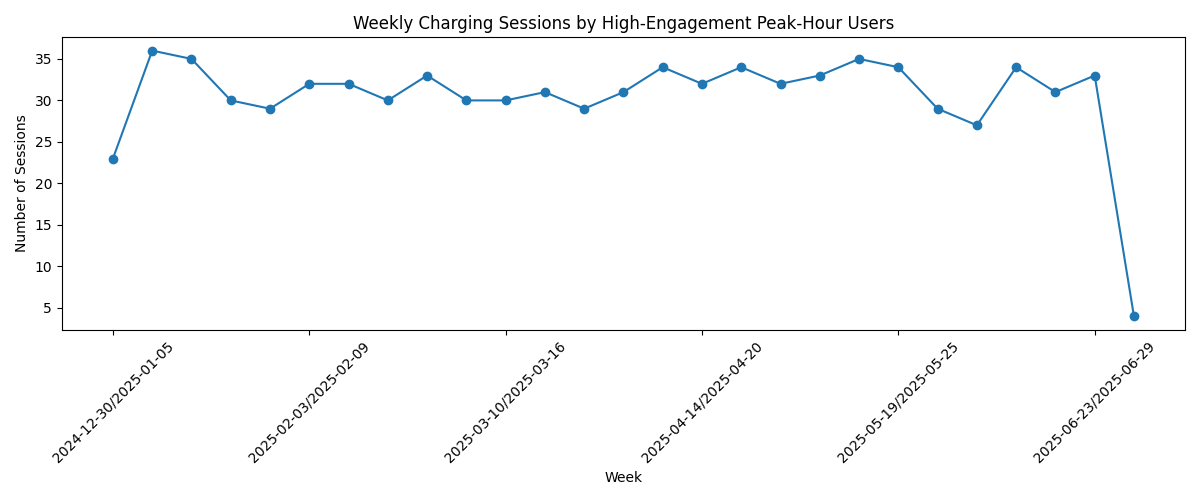

In [33]:
Image.open('./Outputs/peak_user_weekly_trend.png')

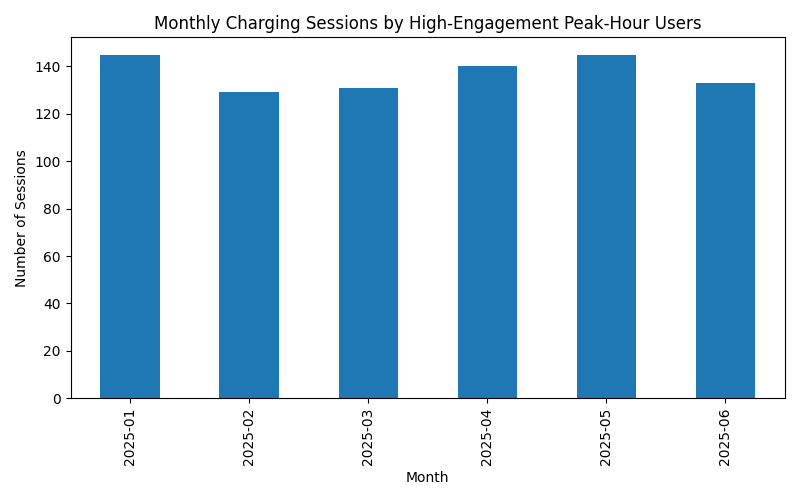

In [34]:
Image.open('./Outputs/peak_user_monthly_trend.png')

## Summary of findings and hypotheses

### Skewed session duration
– While the median session lasts ~2 hours, a long tail of sessions extends into multi‑day charging. These prolonged sessions may correspond to residents leaving vehicles plugged in overnight or vehicles remaining connected despite being fully charged.
Hypothesis: a small group of users with very long sessions contributes disproportionately to overnight energy consumption. Targeting these “resident sleepers” could be effective for demand‑response programs.

### Temporal demand patterns
– Peak demand occurs on weekday evenings (18:00–22:00) and mid‑morning, with weekend demand more evenly distributed.
Hypothesis: bidding strategies for DR events should prioritise weekday evening peaks, while weekends may require a different approach due to the spread of charging times.

### Geographical concentration
– The West and Central zones dominate both session counts and energy delivered, suggesting these areas have the highest charging demand.
Hypothesis: DR events and infrastructure upgrades should focus on these zones, while low‑traffic zones might benefit from promotional incentives to balance load.

### User loyalty and behaviour
– Many customers are highly loyal to a single site. Frequent high‑energy users may represent fleets or individuals without home charging.
Hypothesis: loyalty programs or targeted incentives could encourage these repeat users to participate in DR events; conversely, the presence of opportunistic users with low loyalty ratios suggests a segment that could be influenced by price signals or convenience.

### Seasonal trend
– Both sessions and total kWh show an increasing trend from January through June, with a particularly strong increase in May–June.
Hypothesis: Seasonal factors (e.g., weather, new EV deployments) drive demand upward; forecasting models should incorporate this trend when planning DR events or infrastructure needs.